In [58]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import os
import soundfile as sf

In [59]:
RECORDING_FILE = 'test_8_words.wav'
SAMPLE_RATE = 16000

In [60]:
SEGMENTS_DIR = 'segments'
try:
    os.mkdir(SEGMENTS_DIR)
except FileExistsError:
    pass

In [61]:
y, sr = librosa.load(RECORDING_FILE, sr=SAMPLE_RATE)


In [62]:
def show_waveform(audio, sr):
    fig, ax = plt.subplots(nrows=1)
    librosa.display.waveshow(audio, sr=sr, ax=ax)
    ax.set(title='Envelope view, mono')
    ax.label_outer()

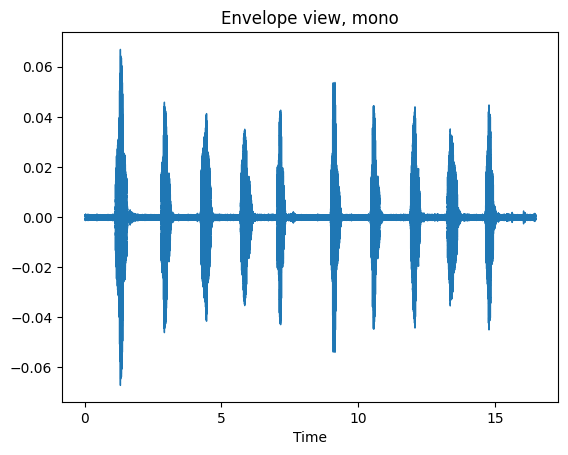

In [63]:
show_waveform(y, sr)

In [64]:
oenv = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.times_like(oenv)
# Detect events without backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv,
                                       backtrack=False)
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)


In [65]:
S = np.abs(librosa.stft(y=y))
rms = librosa.feature.rms(S=S)
onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])

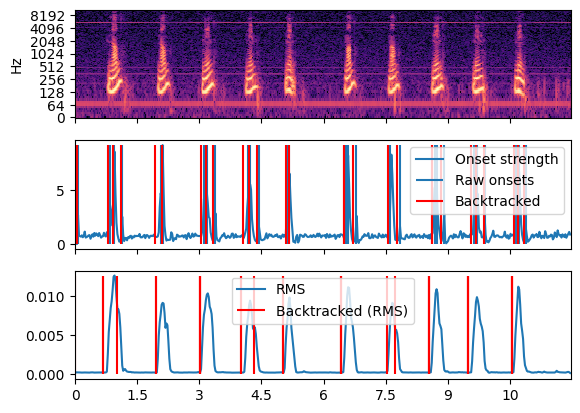

In [66]:
fig, ax = plt.subplots(nrows=3, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].label_outer()
ax[1].plot(times, oenv, label='Onset strength')
ax[1].vlines(librosa.frames_to_time(onset_raw), 0, oenv.max(), label='Raw onsets')
ax[1].vlines(librosa.frames_to_time(onset_bt), 0, oenv.max(), label='Backtracked', color='r')
ax[1].legend()
ax[1].label_outer()
ax[2].plot(times, rms[0], label='RMS')
ax[2].vlines(librosa.frames_to_time(onset_bt_rms), 0, rms.max(), label='Backtracked (RMS)', color='r')
ax[2].legend()


In [67]:
segments_array = librosa.effects.split(y, top_db=30)


In [68]:
def max_segment_length(segments):
    max = 0
    for segment in segments:
        if segment[1] - segment[0] > max:
            max = segment[1] - segment[0]
    return max

max_length = max_segment_length(segments_array)

In [69]:
def generate_padded_segments(segments, size):
    padded_segments = []
    for segment in segments:
        if segment[1] - segment[0] < size:
            padded_segments.append(librosa.util.fix_length(y[segment[0]:segment[1]], size=size))
        else:
            padded_segments.append(y[segment[0]:segment[1]])
    return padded_segments

padded_segments = generate_padded_segments(segments_array, max_length)

In [70]:
for segment in padded_segments:
    display(Audio(data=segment, rate=sr))

In [71]:
words = ['nan', 'nam', 'nin', 'nim', 'nin', 'man', 'mam', 'min', 'mim', 'mim']

In [72]:
def saveEachSegment(segments):
    for i in range(segments.__len__()):
        if i % 5 != 4:
            sf.write(os.path.join(SEGMENTS_DIR, f'{i}-{words[i]}.wav'), segments[i], sr)

saveEachSegment(padded_segments)
